# PC Associative Memory
Purpose: To implement the paper by Salvatori et al [2021]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
#np.core.arrayprint._line_width = 80

np.set_printoptions(edgeitems=30, linewidth=250, 
    formatter=dict(float=lambda x: "% .4f" % x))

# Dataset

In [7]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 2950
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes)
X = 3.*(torch.rand((sensory_dim, n_classes)) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[ 0.3232, -0.9563,  0.5234,  1.4845, -0.3955,  0.9563, -0.8818, -1.4115,
          1.3157,  0.8915],
        [ 1.2468,  0.5938,  0.8025, -1.0985, -1.3189, -0.9960,  0.8459, -0.2334,
          0.5250,  1.1660],
        [-0.8239, -1.1012,  0.0545,  0.2905, -0.4973,  1.3367, -1.4346,  0.9836,
         -0.9238, -0.5371]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [8]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [11]:
blah = SimpleDataset(A, B, n=100, noise=0.1)

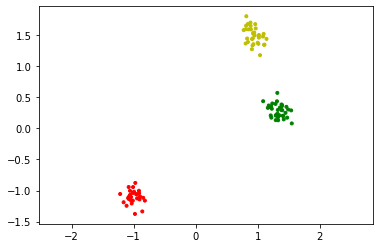

In [12]:
blah.Plot(idx=[5,3])

# Create Network

In [33]:
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=10))  # v0 input
net.AddLayer(PCLayer.PCLayer(n=10))  # e0
net.AddLayer(PCLayer.PCLayer(n=5))   # v1
net.AddLayer(PCLayer.PCLayer(n=5))   # e1
net.AddLayer(PCLayer.PCLayer(n=3))   # v2 embedding

af = 'identity'
sym = True
# Use identity activation for input layer to make it comparable to a FF net
net.Connect(v_idx=0, e_idx=1, type='1to1')
net.Connect(v_idx=2, e_idx=1, type='general', sym=sym, act_text='tanh')
net.Connect(v_idx=2, e_idx=3, type='1to1')
net.Connect(v_idx=4, e_idx=3, type='general', sym=sym, act_text=af)

net.SetTau(0.04)
net.SetGamma(0.2)

In [35]:
#net.con[0].SetIdentity()
#net.con[1].SetIdentity()

In [36]:
#net.Save('my.net')
#net2 = PCNetwork.PCNetwork.Load('my.net')

# Training

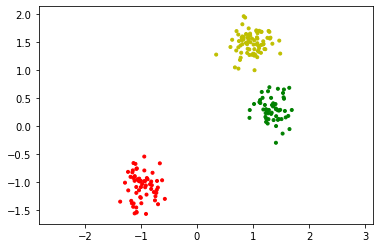

In [37]:
simple_ds = SimpleDataset(A, B, n=200, noise=0.2)
dl = DataLoader(simple_ds, batch_size=25, shuffle=True)
simple_ds.Plot(idx=(5,3))

In [38]:
net.Learn(dl, T=1., epochs=3)

100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


# Classification

In [39]:
net.Reset(random=1.)
net.lyr[-1].Probe(True)
net.Predict(A, T=2.)

tensor([[ 0.9724, -0.0296, -0.0160],
        [ 0.0353,  0.9523, -0.0219],
        [-0.0110, -0.0454,  1.0007]])

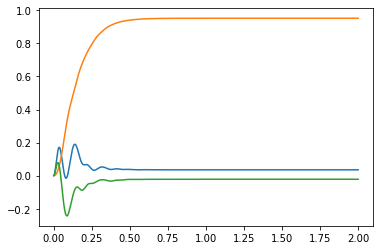

In [40]:
net.lyr[-1].Plot(net.t_history, idx=1)

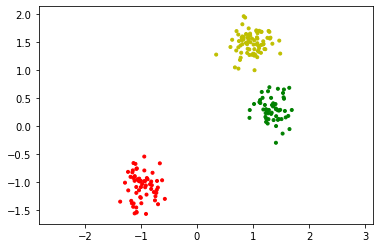

In [41]:
sidx = (5,3)
simple_ds.Plot(labels=net.Predict(simple_ds.Inputs(), T=2.), idx=sidx)